# **Apple leaf disease discovery with Deep Learning and Keras using a Plant Pathology dataset from Kaggle**

Apples are one of the most important temperate fruit crops in the world. Leaf diseases can be a large problem for apple orchards because the diseased plants can have direct repercussions on the number of apples that can be produced and the quality of those apples.  Currrently, apple leaf diseases are discovered by manual labor which can take considerable amounts of time that can be used for production and raise labor costs.

Leaf color and leaf morphology, the age of infected tissues, non-uniform image background, and different light illumination during imaging pose significant limitations to plant disease classification and identification with computer vision models.  A deep learning model using Keras will be developed and trained on part of the training data and subsequently tested on a smaller part of the training data as the Kaggle test set is has only three images.  The Keras model will attempt to classify a given leaf image from the newly created test dataset to a particular disease category.  An effective model could also be used in other plant pathology environments as well and potentially improve plant quality of life as well as fruit quality and labor costs.



### **Loading the data from Kaggle**

Loading data from Kaggle takes a fine tuned approach as demonstrated below. First, the Kaggle API Client must be installed.

In [1]:
# Install the Kaggle API client.
!pip install -q kaggle

Next, the following cell must be ran whereby a kaggle.json file will be uploaded from the Kaggle account settings page.

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"superingram","key":"1b246dd397c077a7254e477449b77fd0"}'}

In [3]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 67 Apr 14 19:36 kaggle.json


This code is very important as you cannot download files from folders on Kaggle without it.

In [4]:
# This code will allow folders to be imported from Kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 3.5MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=ba19adf1cf218903f13216e243736dcc28e157229d23df787108062c77f7ec65
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


The Kaggle API client expects this file to be in the Kaggle directory ~/.kaggle,

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

This permissions change avoids a warning on Kaggle tool startup.

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

Now, the Kaggle data can be downloaded to Google Colab PRO

In [7]:
!kaggle competitions download -c plant-pathology-2021-fgvc8

100% 14.8G/14.9G [03:04<00:00, 88.9MB/s]
100% 14.9G/14.9G [03:04<00:00, 86.5MB/s]


Important imported python packages

In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import glob
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Conv3D, Flatten, MaxPool2D, Dropout, BatchNormalization

Finally, the Kaggle plant pathology zip files can be unzipped and uploaded for analysis. The .zip file will ultimately be deleted after unzipping and the capture command allows us to hide 5000 listed files.

In [9]:
# unzipping the zipped file and deleting the zipped file
%%capture
!unzip \*.zip && rm *.zip 

The training set images will have to be formatted, resized and reduced as there is not enough RAM for all 18000 images.  10240 of the original images will be used as the training set and coordinated with the 'train/csv' file. The resulting set of images will be called "trainset."

In [46]:
# The training images will be formatted and resized.  
# The training set with images will have to be reduced as the RAM will not read in all 18000 images.
# A new test set will be created from some of the remaining training images.

root = '/content/train_images'
def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.resize(img, [128, 128])
    img = tf.cast(img, tf.uint8)
    return img.numpy()

df = pd.read_csv('/content/train.csv')[:10240]

df['image'] = [os.path.join(root, x) for x in df['image']]

trainset = []
for x in (df['image']):
    trainset.append(load_image(x))

### **Exploratory Data Analysis**

In [47]:
df.shape

(10240, 2)

In [48]:
df.head(21)

,image,labels
0,/content/train_images/800113bb65efe69e.jpg,healthy
1,/content/train_images/8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,/content/train_images/80070f7fb5e2ccaa.jpg,scab
3,/content/train_images/80077517781fb94f.jpg,scab
4,/content/train_images/800cbf0ff87721f8.jpg,complex
5,/content/train_images/800edef467d27c15.jpg,healthy
6,/content/train_images/800f85dc5f407aef.jpg,rust
7,/content/train_images/801d6dcd96e48ebc.jpg,healthy
8,/content/train_images/801f78399a44e7af.jpg,complex
9,/content/train_images/8021b94d437eb7d3.jpg,healthy


In [49]:
df.describe()

,image,labels
count,10240,10240
unique,10240,12
top,/content/train_images/a29ab6629a8196bf.jpg,scab
freq,1,2706


The shape of the dataframe is to be expected as here is where the labels will come from.  The summary above states that there are 12 unique labels.  The first 21 labels of the dataframe was displayed to show all of the potential disease categories. 

In [50]:
df['labels'].unique()

array(['healthy', 'scab frog_eye_leaf_spot complex', 'scab', 'complex',
       'rust', 'frog_eye_leaf_spot', 'powdery_mildew',
       'scab frog_eye_leaf_spot', 'frog_eye_leaf_spot complex',
       'rust frog_eye_leaf_spot', 'powdery_mildew complex',
       'rust complex'], dtype=object)

Below is a visualization of the occurrence of different types of disease in the training set using the seaborn package.  The labels are not evenly distributed.  More importantly, some labels consist of spaces with will be a problem for a deep neural network.  Only six of the most common diseases will be used since the other labels look to be conglomerations of other diseases.

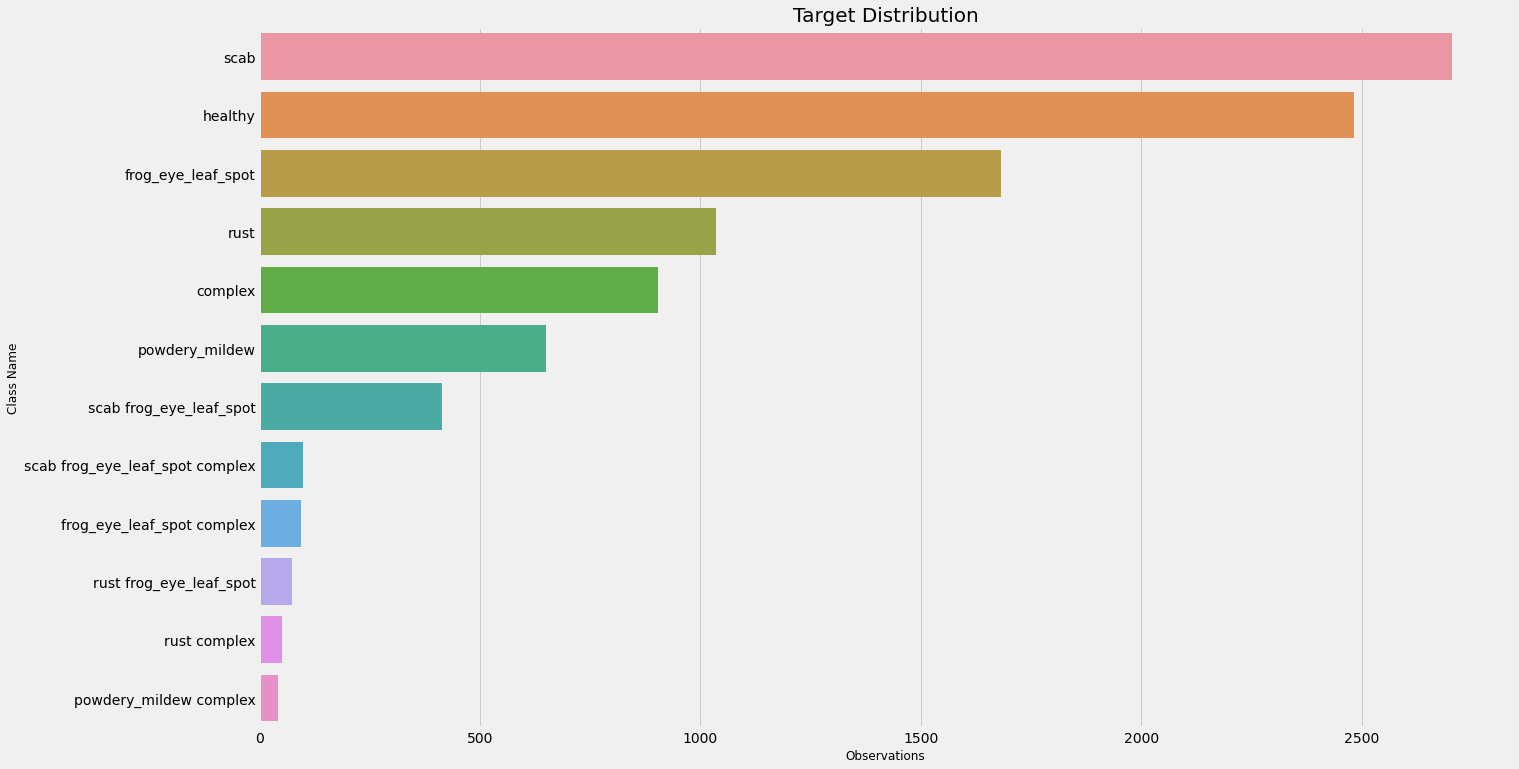

In [51]:
targets=df.labels.value_counts()
fig = plt.figure(figsize=(20,12))
sns.barplot(y=targets.sort_values(ascending=False).index, x=targets.sort_values(ascending=False).values)
plt.title('Target Distribution', size = 20)
plt.xlabel("Observations", size=12)
plt.ylabel("Class Name", size=12)
plt.show()

The test images will be read into an array for display since there is only three.

In [ ]:
folders = glob.glob('/content/test_images*')
image_names = []
for folder in folders:
    for f in glob.glob(folder+'/*.jpg'):
        image_names.append(f)

test_images = []        
for image in image_names:
    test_images.append(cv2.imread(image))
    

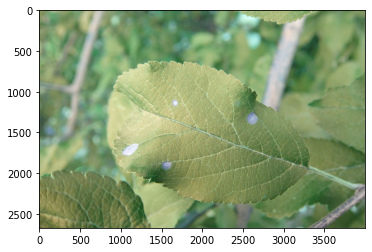

In [ ]:
# Displaying the first test image.
plt.imshow(test_images[0])

The first image has a length of 2672 and a width of 4000 with a depth of three channels indicating a color image.

In [ ]:
test_images[0].shape

(2672, 4000, 3)

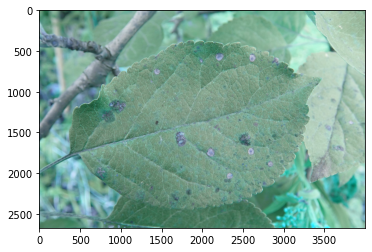

In [ ]:
# Displaying the second test image.
plt.imshow(test_images[1])

The second image has the same length, width and depth as the second.

In [ ]:
test_images[1].shape

(2672, 4000, 3)

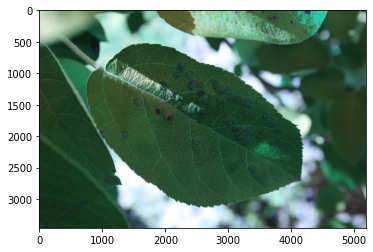

In [ ]:
# Displaying the third test image.
plt.imshow(test_images[2])

The third image has a length of 3456 and a width of 5184 !

In [ ]:
test_images[2].shape

(3456, 5184, 3)

### **A little bit of Feature Engineering and Data Wrangling**

A class will be creaded to compare labels against as only the six most relevant classes of disease will be used. 

In [16]:
plt.style.use('fivethirtyeight')

class BDI:
    
    root = '/content/train_images'
    classes = [
        'complex', 
        'frog_eye_leaf_spot', 
        'powdery_mildew', 
        'rust', 
        'scab',
        'healthy']
    strategy = tf.distribute.get_strategy()
    batch_size = 16


The MultiLabelBinarizer is used to remove whitespace in the labels and create a format usable for a Keras neural network model.

In [52]:
df.set_index('image', inplace=True)

init_labels = df['labels'].values.copy()

df['labels'] = [x.split(' ') for x in df['labels']]
labels = MultiLabelBinarizer(classes=BDI.classes).fit_transform(df['labels'].values)

train = pd.DataFrame(columns=BDI.classes, data=labels, index=df.index)

train.head()

,complex,frog_eye_leaf_spot,powdery_mildew,rust,scab,healthy
image,,,,,,
/content/train_images/800113bb65efe69e.jpg,0,0,0,0,0,1
/content/train_images/8002cb321f8bfcdf.jpg,1,1,0,0,1,0
/content/train_images/80070f7fb5e2ccaa.jpg,0,0,0,0,1,0
/content/train_images/80077517781fb94f.jpg,0,0,0,0,1,0
/content/train_images/800cbf0ff87721f8.jpg,1,0,0,0,0,0


The dataframe still has 10240 rows and now, 6 columns.

In [53]:
train.describe

<bound method NDFrame.describe of                                             complex  ...  healthy
image                                                ...         
/content/train_images/800113bb65efe69e.jpg        0  ...        1
/content/train_images/8002cb321f8bfcdf.jpg        1  ...        0
/content/train_images/80070f7fb5e2ccaa.jpg        0  ...        0
/content/train_images/80077517781fb94f.jpg        0  ...        0
/content/train_images/800cbf0ff87721f8.jpg        1  ...        0
...                                             ...  ...      ...
/content/train_images/c6a634cbb08a6dcb.jpg        0  ...        0
/content/train_images/c6a69190e5fc2576.jpg        0  ...        0
/content/train_images/c6aed22d906bb523.jpg        0  ...        0
/content/train_images/c6af7edb2f912001.jpg        0  ...        0
/content/train_images/c6b214c2ac455f3f.jpg        0  ...        1

[10240 rows x 6 columns]>

This is what the training images will look like to humans but not necessarily to a computer.

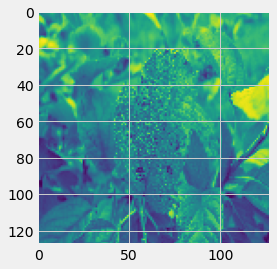

In [54]:
plt.imshow(trainset[400].reshape(128, 128))

A test set will now be created from the training set using the same methods so that there are plenty of images to predict.  

In [55]:
tester = pd.read_csv('/content/train.csv')[10241:12800]

tester['image'] = [os.path.join(root, x) for x in tester['image']]

test_set = []
for x in (tester['image']):
    test_set.append(load_image(x))

The MultiLabelBinarizer is used again remove whitespace in our labels for the test set.

In [56]:
tester.set_index('image', inplace=True)

test_init_labels = tester['labels'].values.copy()

tester['labels'] = [x.split(' ') for x in tester['labels']]
test_labels = MultiLabelBinarizer(classes=BDI.classes).fit_transform(tester['labels'].values)

test = pd.DataFrame(columns=BDI.classes, data=test_labels, index=tester.index)

test.head()

,complex,frog_eye_leaf_spot,powdery_mildew,rust,scab,healthy
image,,,,,,
/content/train_images/c6b460353d77c362.jpg,0,0,0,0,1,0
/content/train_images/c6b4b491f27e4349.jpg,1,0,0,0,0,0
/content/train_images/c6b50cf4bd087374.jpg,0,0,0,0,1,0
/content/train_images/c6b833780fe5c34a.jpg,1,0,0,0,0,0
/content/train_images/c6bc9352f4466627.jpg,0,0,0,0,0,1


Dimensionality reduction

In [57]:
trainset = np.array(trainset)/255.0
test_set = np.array(test_set)/255.0

Final inspection of the data

In [58]:
trainset.shape

(10240, 128, 128, 1)

In [59]:
test_set.shape

(2559, 128, 128, 1)

In [60]:
labels.shape

(10240, 6)

In [63]:
test_labels.shape

(2559, 6)

The shape of the train set and test set with their respective labels are as they should be.

### **The Keras convolutional neural network (CNN)**

In [168]:
# Initializes a sequential CNN model
model = Sequential()

# Add a convolutional layer
model.add(Conv2D(16, kernel_size=3, activation='relu', 
               input_shape=(128, 128, 1)))

# Add batch normalization layer
model.add(BatchNormalization())

# Add a pooling layer
model.add(MaxPool2D(2))

# Add a dropout layer
model.add(Dropout(0.5))

# Add another convolutional layer
model.add(Conv2D(8, kernel_size=3, activation='relu'))

# Add batch normalization layer
model.add(BatchNormalization())

# Add a pooling layer
model.add(MaxPool2D(2))

# Add a dropout layer
model.add(Dropout(0.5))

# Add a third convolutional layer
model.add(Conv2D(16, kernel_size=3, activation='relu'))

# Add batch normalization layer
model.add(BatchNormalization())

# Add a pooling layer
model.add(MaxPool2D(2))

# Add a dropout layer
model.add(Dropout(0.5))

# Flatten the output of the last convolutional layer
model.add(Flatten())

# Add one last dense layer
model.add(Dense(64, activation='sigmoid'))

# Output layer
model.add(Dense(6, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', 
           loss='categorical_crossentropy', 
           metrics=['accuracy'])


This CNN consists of three convolutional layers, a dense hidden layer and an output layer.  Relu activation is utiilized with an 'adam' optimizer.  Each convolutional layer has a kernel size of 3 and is followed by batch normalization, max pooling of 2 and a drop out layer with a value of 0.5 since padding was not utilized. The model was flattened after the last convolutional layer.

In [184]:
print(model.summary())

Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_118 (Conv2D)          (None, 126, 126, 16)      160       
_________________________________________________________________
batch_normalization_116 (Bat (None, 126, 126, 16)      64        
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 63, 63, 16)        0         
_________________________________________________________________
dropout_100 (Dropout)        (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 61, 61, 8)         1160      
_________________________________________________________________
batch_normalization_117 (Bat (None, 61, 61, 8)         32        
_________________________________________________________________
max_pooling2d_86 (MaxPooling (None, 30, 30, 8)       

In [169]:
# Fit the model
model.fit(trainset, labels, validation_split=0.2, epochs=3, batch_size=20, callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/3
410/410 [==============================] - 4s 8ms/step - loss: 1.7402 - accuracy: 0.3166 - val_loss: 2.2953 - val_accuracy: 0.1265
Epoch 2/3
410/410 [==============================] - 3s 7ms/step - loss: 1.5241 - accuracy: 0.4184 - val_loss: 1.9299 - val_accuracy: 0.2803
Epoch 3/3
410/410 [==============================] - 3s 7ms/step - loss: 1.4899 - accuracy: 0.4484 - val_loss: 2.0148 - val_accuracy: 0.3462


In [170]:
# Evaluate the model
model.evaluate(test_set, test_labels, batch_size=10)

256/256 [==============================] - 1s 3ms/step - loss: 2.0972 - accuracy: 0.3400


[2.097191333770752, 0.33997654914855957]

### **Conclusion**

While the accuracy of the CNN was not good, there may be a number of reasons for this and a number of methods that ca be used to improve the model. 

The first issue is that there is not enough RAM available to read the images into Google Colab as is using the size of trainig dataset that was selected.  The number of images in the training set could be reduced (as well as the test set) so that higher quality images could be read into Google Colab.  

Additionally, leaf color and leaf morphology, non-uniform image background, and different light illumination during imaging may require that the images be processed in a more thorough way so that some uniformity with the original clarity can be achieved.  This may produce a model that could be deployed on larger datasets increasing accuracy for entire orchards.

The Keras model may still need more hidden layers added to it or the batch size may need increased.  The optimum use of activation functions were for the convolutional layers to use Relu activation while the dense layer was added with a sigmoid activation function.  Drop out layers and early stopping were utilized to avoid over-fitting the training data.  

The last modification may very well be the use of PyTorch as PyTorch is more advanced with some of the object-oriented programming functions that can be utilized.  While the accuracy is not what we want, there are many methods that can be employed for improvement of the CNN model.